# PyStorm Walkthrough

In [2]:
# basic imports for working with matrices and plotting
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
#import nengo


This guide will introduce you to PyStorm, a Python package that exposes abstractions of Braindrop's hardware constructs as network objects. Basic familiarity with PyStorm's network objects is assumed (see first 2 pages of __braindrop_pystorm_documentation.pdf__). 

The outline for this walkthrough is as follows:
1. Creating a 1D pool and its tap-point matrix
2. Sending inputs and measuring spikes
3. Decoding functions
4. Visualizing tuning curves

*** NOTE ***

Below we've provided a cell for resetting the chip's connection to the server. In most cases, this code will be unnecessary. However, sometimes when the initial handshake occurs (during the `HAL()` call in the tutorial code below), the USB connection fails and the Python call quickly raises the error messeage `Comm failed to init`. If this happens, run this cell below to reset the connection and try again. This may take a few tries for it to reconnect.

In [3]:
!sudo /home/ee207student/usbreset.sh # reset the USB connection, which sometimes dies.
# if Comm below is repeatedly & quickly failing to init, you can run this cell.

'sudo' is not recognized as an internal or external command,
operable program or batch file.


*** END NOTE ***

## PyStorm Imports

In [4]:
############################################################################
# Importing essential PyStorm libraries

# HAL, or Hardware Abstraction Layer, must be imported and initialized
from pystorm.hal import HAL
HAL = HAL()

# data_utils contains a useful function for binning spikes and estimating spike rates
from pystorm.hal import data_utils

# RunControl objects are responsible for executing command sequences on the chip, such as initiating
# tuning curve measurements
from pystorm.hal.run_control import RunControl

# Graph objects represent properties of your network
# so that HAL can allocate resources for them on the chip
from pystorm.hal.neuromorph import graph 

## 1 Creating a 1D Pool and Tap Point Matrix

Let's review basic requirements for building and simulating an ensemble with PyStorm (for syntax definitions, see __braindrop_pystorm_documentation.pdf__).

### 1.1 Defining a pool's parameters and its tap-point matrix
Define your neuron array's width $W$ and height $H$, such that the ensemble's size is $N = WH$, and the dimensionality $D$ of its input space. Then, construct a $N$-by-$D$ tap-point matrix `tap_matrix`, which specifies an _anchor encoder_ for each tap-point used. For instance, in Problem Set 3, you defined tap points on a 1-D diffuser with plus and minus signs ($+1$ or $-1$). In $D$ dimensions, these anchor encoders are $D$-dimensional vectors in $\{-1, 0, +1\}^D$. When we use a 2-D diffuser to create two-dimensional encoders, we draw the tap-points' anchor encoders from $\{-1, 0, +1\}^2$.

Although a $N$-by-$D$ matrix can specify all $N$ anchor encoders, a $N$-neuron pool has only $N/4$ tap-points—since there is 1 synaptic filter per $2\times2$ cluster of neurons. If you specify more than $N/4$ anchor encoders, HAL will throw an error when it tries to create your network. 

The code below implements an algorithm that assigns 1-D anchor encoders to tap-points. It's quite simple:
- Divide the set of tap-points in half along the width axis 
- Assign one side $[+1]$ anchor encoders and the other half $[-1]$ anchor encoders. 

`plot_tap_matrix()` visualizes the results within the $W$-by-$H$ neuron array. Free parameter $\rho$ controls tap-point density by skipping synapses. Try changing this parameter to create different tap-point matrices.

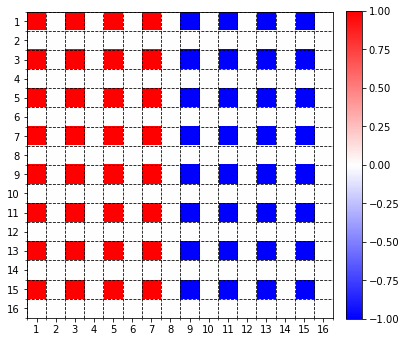

In [10]:
def tap_mat_1d(width, height, rho=0):
    '''
    Creates a structured 1D tap-point matrix
    
    Parameters
    ----------
    width: int
        Width of neuron array
    height: int
        Height of neuron array
    rho: int
        1/2**rho is the fraction of total tap-points the 
        algorithm should use
    
    Returns
    -------
    tap_matrix: numpy matrix
        width*height x 2 tap-point matrix
    '''
    # creating an empty tap-point matrix
    tap_matrix = np.zeros((N, Din))

    # one synaptic filter per 4 neurons
    for x in range(2**rho - 1, width, 2 * 2**rho):
        for y in range(2**rho - 1, height, 2 * 2**rho):
            n = y * width + x
            if x < width // 2:
                tap_matrix[n, 0] = 1
            else:
                tap_matrix[n, 0] = -1
    return tap_matrix

def plot_tap_matrix(matrix, width, height):
    '''
    Plots single dimension of a tap-point matrix with a given width and height
    '''
    plt.imshow(matrix.reshape((height, width)), cmap='bwr', vmin=-1, vmax=1, interpolation='none', aspect='equal')
    plt.colorbar(fraction=0.046, pad=0.04)
    ax = plt.gca()
    ax.set_yticks(np.arange(0, height, 1))
    ax.set_xticks(np.arange(0, width, 1))
    ax.set_yticklabels(np.arange(1, height+1, 1));
    ax.set_xticklabels(np.arange(1, width+1, 1));
    ax.set_yticks(np.arange(-.5, height, 1), minor=True);
    ax.set_xticks(np.arange(-.5, width, 1), minor=True);

    plt.grid(which='minor', color='k', linestyle='--')

############################################################################
# Creating pool parameters and a tap-point matrix

# width, height, and size of a 1D pool
width = 16
height = 16
width_height = (width, height)
N = width * height
Din = 1
rho = 0
tap_matrix = tap_mat_1d(width, height, rho=rho)

# plotting the matrix
plt.figure(figsize=(6,6))
plot_tap_matrix(tap_matrix, width, height)

### 1.2 Creating the pool and its connections
Now that we've selected our pool's width (16), height (16), dimensionality (1), and tap-point matrix, we may create an actual network. We do this by defining input and output nodes, for incoming and outgoing signals, a pool of neurons, and a bucket to accumulate their spikes. Then we connect these network objects to create a graph object.

In [20]:
############################################################################
# Creating a pool and its connections

# create the network as a graph object, named "simple_net" here, which tracks 
# connections and configuration parameters for the network's objects.
simple_net = graph.Network("simple_net")

# decoders are initially zero, we remap them later (without touching the rest of the network)
# using HAL.remap_weights()
Dout = 1
decoders = np.zeros((Dout, N))

# create and name the input and specify its dimensionality
i1 = simple_net.create_input("i1", Din)

# create and name the neuron pool and supply the computed tap-point matrix.
# explicitly set the biases here; you will optimize these in
# the next problem. All neurons have their bias set to -3.
p1 = simple_net.create_pool("p1", tap_matrix, biases=-3)

# create and name the bucket and specify its dimensionality
b1 = simple_net.create_bucket("b1", Dout)

# create and name the output and specify its dimensionality
o1 = simple_net.create_output("o1", Dout)

# connect the input to the pool
# "None" is for the weights field; only connections to buckets can have weights
simple_net.create_connection("c_i1_to_p1", i1, p1, None)

# connect the pool to the bucket and specify initial weights
decoder_conn = simple_net.create_connection("c_p1_to_b1", p1, b1, decoders)

# connect the bucket to the output
simple_net.create_connection("c_b1_to_o1", b1, o1, None)

Connection c_b1_to_o1 from b1 to o1

### 1.3 Setting up HAL to map the defined network
HAL instantiates our network on Braindrop and allocates resources to it. To do this, we have to first configure Braindrop's and the host machine's time-bins (i.e., time-resolution). Then, we `map(net)`, the Graph object (defined in 2.1.3). We must redo this call any time we change `net`'s properties.

In [21]:
############################################################################
# Setting up the HAL interface and mapping the network

# misc driver parameters: downstream refers to Braindrop and upstream refers to the host
downstream_time_res = 10000 # ns, or 10us
upstream_time_res = 1000000 # ns, or 1ms

HAL.set_time_resolution(downstream_time_res, upstream_time_res)

# invoke HAL.map(), make tons of neuromorph/driver calls under the hood
# to map the network
print("calling map")
HAL.map(simple_net)

calling map


## 2 Sending Inputs and Measuring Spike Rates

In order to drive Braindrop with a stimulus $x(t)$, PyStorm requires you to specifiy its values at particular times and a value for the parameter $f_\mathrm{max}$. The stimulus $-1 < x(t) < +1$ is streamed to Braindrop as a periodic train of impulses with instantaneous rate $-f_\mathrm{max} < f_\mathrm{max}x(t) < +f_\mathrm{max}$, where the minus sign denotes an impulse with area -1 instead of +1.

### 2.1 Example input signals
The functions `make_cons_stimulus()` and `make_sine_stimulus()` demonstrate two different inputs that are useful for measuring neurons' firing properties.

`make_cons_stimulus()` creates a D-dimensional stimulus that steps through all points in a uniformly-gridded space $[-f_\mathrm{max},+f_\mathrm{max}]^D$. This signal's value equals each of $Q^D$ points for a constant amount of time. It's used to sweep a $D$-dimensional space and measure the neurons' responses. That yields estimates for their firing-rates using bin-widths equal to `hold_time`. Such box-car filtering isn't what the synapse does, however. Thus, it yields a wrong estimate for firing-rates' noise. Training decoders using these firing-rate estimates therefore does not produce optimal decoders.

`make_sine_stimulus()` creates a multidimensional sinusoidal stimulus with amplitude $f_\mathrm{max}$, period `base_period`, and duration given in `cycles` of `base_period`. Note that it's constant over a step size `input_dt`. Each dimension's ($D_i$) sinusoid oscillates at frequency $\phi^{-D_i}/T$, where $\phi$ is the golden ratio $\frac{1+\sqrt{5}}{2}$ and $T$ is the first-dimension's period, specified by `base_period`. This scaling ensures no pair of dimensions ever synchronize. As a result, the full domain $[-1,1]^D$ is swept. When used to train decoders with `base_period` equal to $2\pi\tau_s$, where $\tau_s$ is the synapses' time-constant, it yields reasonable firing-rate noise estimates (after lowpass filtering with time-constant $\tau_s$) that can be used to train optimal decoders (section 3).

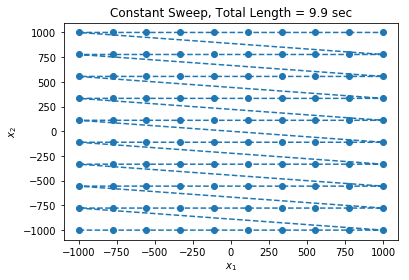

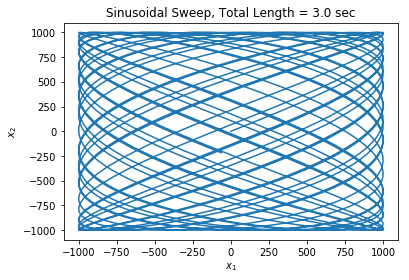

In [6]:
def make_cons_stimulus(Din, hold_time, points_per_dim, fmax=1000):
    '''
    Creates multidimensional staircase-like signal
    
    Parameters
    ----------
    Din: int
        Dimensionality
    hold_time: float (seconds)
        Duration of each sample
    points_per_dim: int
        Number of samples per dimension
    fmax: float
        Converts |x| < 1 to firing rate
    
    Returns
    -------
    inp_times: numpy array
        Length-S array of times a new sample starts (in seconds) 
    inputs: numpy matrix
        S-by-Din matrix of samples (in units of firing rate)
    '''
    total_points = points_per_dim ** Din
    stim_rates_1d = np.linspace(-fmax, fmax, points_per_dim).astype(int)
    if Din > 1:
        stim_rates_mesh = np.meshgrid(*([stim_rates_1d]*Din))
    else:
        stim_rates_mesh = [stim_rates_1d]
    stim_rates = [r.flatten() for r in stim_rates_mesh]
    inputs = np.array(stim_rates).T
    
    inp_times = np.arange(0, total_points) * hold_time
    return inp_times, inputs

def make_sine_stimulus(Din, base_period, cycles, fmax=1000, input_dt=1e-3):
    '''
    Creates multidimensional sinusoidal signal
    
    Parameters
    ----------
    Din: int
        Dimensionality
    base_period: float (seconds)
        Period of oscillation for first dimension
    cycles: float
        Number of cycles the signal is generated for
    fmax: float
        Converts |x| < 1 to firing rate
    input_dt: float
        Step-size during which rate is held constant (in seconds)
        
    Returns
    -------
    inp_times: numpy array
        Length-S array of times a new sample starts (in seconds) 
    inputs: numpy matrix
        S-by-Din matrix of samples (in units of firing rate)
    '''
    phi = (1 + np.sqrt(5))/2.0
    freq = 1/base_period
    f = ((1/phi)**np.arange(Din)) * freq
    stim_func = lambda t: np.sin(2*np.pi*f*t)
    
    sim_time = cycles * base_period

    inp_times = np.arange(int(sim_time/input_dt))*input_dt
    inputs = np.zeros((len(inp_times), Din))

    for index, t in enumerate(inp_times):
        v = stim_func(t)

        for i, vv in enumerate(v):
            ff = int(vv*fmax)
            if ff == 0:
                ff = 1

            inputs[index, i] = float(ff)

    return inp_times, inputs

############################################################################
# Plotting example stimuli

Dstim = 2
hold_time = 0.1
Q = 10
times, inp = make_cons_stimulus(Dstim, hold_time, Q)
plt.figure()
plt.plot(inp[:,0], inp[:,1], '--o')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Constant Sweep, Total Length = %.1f sec' % times[-1])

Dstim = 2
base_period = 0.1
cycles = 30
times, inp = make_sine_stimulus(Dstim, base_period, cycles)
plt.figure()
plt.plot(inp[:,0], inp[:,1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Sinusoidal Sweep, Total Length = %.1f sec' % times[-1]);

### 2.2 Sending inputs and collecting spikes
To send stimuli to Braindrop, we use the `RunControl` object, telling it what the stimulus is, where it should go, and for how long it should be measured. It returns spike or output data back to the host, binned with a resolution defined by the `upstream_time_res` parameter (set earlier).

In this example, you will use `make_sine_stimulus()` to stimulate your pool, with `base_period` equal to $2\pi\tau_s$, where $\tau_s$ is the average synaptic time-constant. In order to select the number of cycles, note that each cycle results in approximately 2 uncorrelated samples of the input space. If you want $Q$ samples per dimension, you should use $(Q/2)^D$ cycles to measure the firing rate. To be conservative, quadruple this number.

In [1]:
############################################################################
# Sending inputs and collecting spikes

# define input parameters
Din = 1
fmax = 1000 # Hz
input_dt = 1e-3 # s
tau_syn = 0.02 # 20 ms
base_period = 2*np.pi*tau_syn # approximately 125 ms

# approximate samples per dimension
Q = 20
cycles = 4* ((Q / 2)**Din) # 4*10^D cycles, or 5 sec for D=1, 50 sec for D=2

# create the stimulus
inp_times, inputs_sin = make_sine_stimulus(Din, base_period, cycles, fmax=fmax, input_dt=input_dt)

# package together the inputs and their timestamps
# times must be sent in ns (and thus are multiplied by 1e9)
FUDGE = 2
curr_time = HAL.get_time()
times = curr_time + FUDGE * 1e9 + inp_times * 1e9
times_w_end = np.hstack((times, times[-1] + input_dt * 1e9))
input_vals = {i1 : (times, inputs_sin)}

# create the RunControl object for our defined network
rc = RunControl(HAL, simple_net)

# send inputs and collect spikes
print("getting spikes")
_, spikes_and_bin_times = rc.run_input_sweep(input_vals, get_raw_spikes=True, 
                                             end_time=times_w_end[-1], rel_time=False)
print("done")

# spike_bin_times is length-S, bin-size set by upstream_time_res
# spike_dict is a dictionary, spike_ct is a S-by-N matrix of spike counts within S bins
spike_dict, spike_bin_times = spikes_and_bin_times
spike_ct = spike_dict[p1]

# convert spike counts to spike trains
spikes = spike_ct / input_dt

# truncate inputs to length of measured outputs
inp_times_trunc = inp_times[:spikes.shape[0]]
inputs_sin_trunc = inputs_sin[:spikes.shape[0]]

NameError: name 'np' is not defined

## 3 Decoding Functions

<img src="brainstorm_diagram.png" width="600">

Let's analyze how to decode functions using the above architecture as an example. It depicts a `graph` object with two pools, `poolA` and `poolB`, each with their own tap-point matrices and synapses. The input node sends spikes at rate $f_\mathrm{max}x(t)$ to `poolA`'s synapses, as specified by the pool's tap-point matrix. The synaptic current spreads through the diffuser and drives neurons in `poolA` to spike. These spikes are collected in `bucketAB` and thinned to decode a desired function $f(x)$. Once `bucketAB` emits its a decoded spike-train, $f_\mathrm{max}f(x)$, it is filtered through `poolB`'s synapses, as specified in its tap-point matrix, before spreading through the diffuser and driving `poolB`'s neurons. To decode some other function $g(x)$ from `poolB`'s spike-train, we connect `poolB` to `bucketBOut`. This bucket thins the spike-train with its own set of decode weights and sends the result to the host through an output node.

We start as we did in the beginning: build the graph, apply a stimulus, and collect spikes. Since we will use this data to train decoders, we use a stimulus that (1) fully spans the input space, and (2), produces the correct amount of noise in the filtered spike-trains. This is essential for training decoders that are optimal for Braindrop. Thus, we use `make_sine_stimulus()` with `base_period` equal to $2\pi\tau_A$, where $\tau_A$ is the synaptic time-constant for pool A. Note that since we have composed two "layers", we will need to train each pool's decoders independently. We will build the full graph below and train their seperate decoders in two stages.


In [27]:
############################################################################
# building the graph

# pool A parameters
DinA = 1
DoutA = 1
widthA = 16
heightA = 16
tau_syn_A = 0.02 # 20ms
rhoA = 1
Na = widthA * heightA
tap_mat_A = tap_mat_1d(widthA, heightA, rho=rhoA)
xy_loc_A = (0, 0) # select pool starting at top-left = (0, 0)

# pool B parameters
DinB = 1
DoutB = 1
widthB = 16
heightB = 16
tau_syn_B = 0.02 # 20ms
rhoB = 1
Nb = widthB * heightB
tap_mat_B = tap_mat_1d(widthB, heightB, rho=rhoB)
xy_loc_B = (16, 0) # select pool starting at top-left = (16,0)

# decoders are initially zero, we remap them later (without touching the rest of the network)
# using HAL.remap_weights()
decoders_AB = np.zeros((DoutA, Na))
decoders_BOut = np.zeros((DoutB, Nb))

net = graph.Network("net")

# creating the network objects
iA = net.create_input("iA", DinA)
pA = net.create_pool("pA", tap_mat_A, biases=-3, user_xy_loc=xy_loc_A)
pB = net.create_pool("pB", tap_mat_B, biases=-3, user_xy_loc=xy_loc_B)
bucketAB = net.create_bucket("bAB", DoutA)
bucketBOut = net.create_bucket("bBOut", DoutB)
oB = net.create_output("oB", DoutB)

# connecting the network objects
net.create_connection("c_iA_to_pA", iA, pA, None)
decoder_AB_conn = net.create_connection("c_pA_to_bAB", pA, bucketAB, decoders_AB)
net.create_connection("c_bAB_to_pB", bucketAB, pB, None)
decoder_BOut_conn = net.create_connection("c_pB_to_bBOut", pB, bucketBOut, decoders_BOut)
net.create_connection("c_bBOut_to_oB", bucketBOut, oB, None)

# mapping the network
HAL.map(net)

############################################################################
# creating a stimulus

# defining the stimulus parameters
fmax = 1000 # Hz
input_dt = 1e-3 # s
base_period = 2*np.pi*tau_syn_A # approximately 125 ms
Q = 20
cycles = 4* ((Q / 2)**DinA) # 4*10^D cycles, or 5 sec for D=1, 50 sec for D=2

# creating the stimulus
inp_times, inputs_sin = make_sine_stimulus(DinA, base_period, cycles, fmax=fmax, input_dt=input_dt)

############################################################################
# collecting spikes

# packaging the stimulus and its time-stamps
FUDGE = 2
curr_time = HAL.get_time()
times = curr_time + FUDGE * 1e9 + inp_times * 1e9
times_w_end = np.hstack((times, times[-1] + input_dt * 1e9))
input_vals = {iA : (times, inputs_sin)}

# collecting spikes
rc = RunControl(HAL, net)
print("getting spikes")
_, spikes_and_bin_times = rc.run_input_sweep(input_vals, get_raw_spikes=True, 
                                             end_time=times_w_end[-1], rel_time=False)
print("done")

# parsing the spike data
spike_dict, spike_bin_times = spikes_and_bin_times
spike_ct_A = spike_dict[pA]
# spike_ct_B = spike_dict[pB]
spikes_A = spike_ct_A / input_dt
# spikes_B = spike_ct_B / input_dt
inp_times_trunc = inp_times[:spikes_A.shape[0]]
inputs_sin_trunc = inputs_sin[:spikes_A.shape[0]]

getting spikes
done


### 3.1 Training decoders
In this subsection, we train two sets of decoders, `decoders_AB` and `decoders_BOut`. To do this, we solve a least-squares problem between firing-rate measurements $\mathbf{A}$ and a target decode $\mathbf{f}$. 

First consider solving for `decoders_AB`. We want to choose decoders such that when the thinned spike-train from pool A is filtered by $\tau_b$, the firing-rate estimate produced represents $f(x)$. Thus to build our firing-rate matrix $\mathbf{A}_\mathrm{a}$, we will filter pool A's $N$ spike-trains (stored in the $S$-by-$N$ matrix `spikes_A`) with time-constant $\tau_b$. To compute the target decode $\mathbf{f}_\mathrm{b}$, follow the path of the input stimulus `inputs_sin`. It's filtered by pool A's synapses, with time-constant $\tau_a$, transformed by `bucketAB`'s accumulators, and finally drives pool B's neurons through synapses with time-constant $\tau_b$. Thus to compute $\mathbf{f}_\mathrm{b}$, we will first filter `inputs_sin` with time-constant $\tau_a$, then apply the desired transformation $f$, and finally filter the transformed signal with $\tau_b$ to obtain $y(t)$. Solving $\mathbf{A}_\mathrm{a}\mathbf{d}_\mathrm{ab} = \mathbf{y}$ thus yields decoders that drive pool B with the desired signal $f(x(t))$. In other words, if $x(t)$ is the stimulus `make_sine_stimulus()` returns, then.

$$
\tau_a\dot{\tilde{x}} + \tilde{x}(t) = x(t)
$$
$$
\tau_b\dot{y} + y(t) = f(\tilde{x}(t))
$$ 

After finding the decoders, you must ensure thir weights are at most 1, since this is the largest weight that can be implemented by thinning. If this is not the case, rescale all the decoders by $\max(|d_i|)$ and redefine $f_\mathrm{max}' = f_\mathrm{max}/\max(|d_i|)$. Then, convert rates to $f(x)$ by dividing the decode by $f_\mathrm{max}'$ instead of $f_\mathrm{max}$.

Text(0.5,1,'RMSE = 0.022')

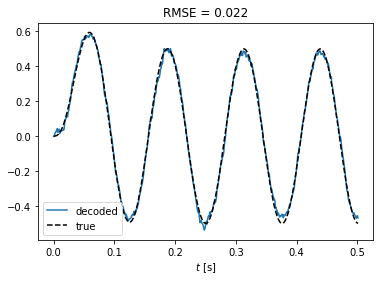

In [29]:
############################################################################
# Training decoders and evaluating training error

# create filter objects
syn_A = nengo.synapses.Lowpass(tau_syn_A)
syn_B = nengo.synapses.Lowpass(tau_syn_B)

# here we demonstrate the function f(x) = x and g(x) = x
func_f = lambda x: x
func_g = lambda x: x

# create a firing-rate matrix for pool A by filtering with pool B's synapses
Aa = syn_B.filt(spikes_A, y0=0, dt=input_dt)

# now to make the decoder target f_A
# first filter the input signal through pool A's synapses
x = syn_A.filt(inputs_sin_trunc, y0=0, dt=input_dt)
# then apply the function f
fx = func_f(x)
# then filter through pool B's synapses
f_A = syn_B.filt(fx, y0=0, dt=input_dt)

# use nengo's built-in solver
solver = nengo.solvers.LstsqL2(reg=0.001)
# use solver to find decoders_AB
decoders_AB, _ = solver(Aa, f_A)

# make sure decoders are <= 1
max_d = np.max(np.abs(decoders_AB))
if max_d > 1:
    # if larger, rescale
    fmax_out_A = fmax / max_d
    decoders_AB /= max_d
    print("rescaling by", max_d)
else:
    # otherwise, we use the same scaling
    fmax_out_A = fmax
    
# lets test the decoders on the training data
fhat_A = Aa @ decoders_AB

# rescale to output units
fhat_A_out = fhat_A / fmax_out_A
f_A_out = f_A / fmax

# compute training error
rmse = np.sqrt(np.mean((f_A_out - fhat_A_out)**2))

# plotting 4 periods of data
plt.figure()
plt.plot(inp_times_trunc[:int(4*base_period/input_dt)], 
         fhat_A_out[:int(4*base_period/input_dt)], label='decoded')
plt.plot(inp_times_trunc[:int(4*base_period/input_dt)], 
         f_A_out[:int(4*base_period/input_dt)], '--k', label='true')
plt.xlabel(r'$t$ [s]')
plt.legend()
plt.title('RMSE = %.3f' % rmse)


Now consider solving for `decoders_BOut`. To do this, we will define a new input node `iB` for pool B and apply a stimulus directly. The stimulus will be reconstructed to match pool B's synaptic time-constant $\tau_b$, then used to drive the neurons and collect spikes counts with `rc.run_input_sweep()`.

Let's decide how to use pool B's spikes to train `decoders_BOut`. Pool B's spikes will be thinned in bucket `bBOut` and sent to the host through an output node. If we want to measure its decoded spike-rate, we must set up a probe with some time-constant $\tau_\mathrm{probe}$ to filter the decoded spike-train and estimate its instantaneous spike-rate. Thus, to build the firing-rate measurement matrix $\mathrm{A}_\mathrm{b}$, filter pool B's $N$ spike-trains (stored in `spikes_B`) with the probe's time constant $\tau_\mathrm{probe}$. To compute the target decode $\mathbf{f}_\mathrm{out}$, follow `inputs_sin`'s path. It's filtered with time-constant $\tau_b$, transformed by $g$, and finally, to obtain $z(t)$, filtered again with time-constant $\tau_\mathrm{probe}$. Solving $\mathbf{A}_\mathrm{b}\mathbf{d}_\mathrm{bout} = \mathbf{z}$ thus yields decoders that implement $g(y(t))$. In other words, if $y(t)$ is the stimulus `make_sine_stimulus()` returns, then:

$$
\tau_b\dot{\tilde{y}} + \tilde{y}(t) = y(t)
$$
$$
\tau_\mathrm{probe}\dot{z} + z(t) = g(\tilde{y}(t))
$$

Note that after solving for the decoders, you must again ensure that its weights are at most 1, or rescale if this is not the case.

getting spikes
done


Text(0.5,1,'RMSE = 0.010')

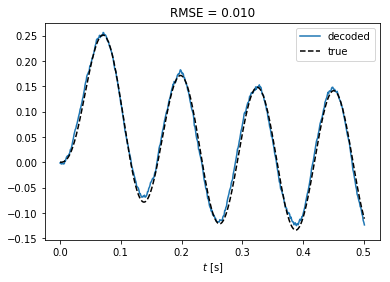

In [54]:
# create an input node for pool B and connect it
iB = net.create_input("iB", DinB)
net.create_connection("c_iB_to_pB", iB, pB, None)
# remap the network with HAL
HAL.map(net)

# defining the stimulus parameters
fmax = 1000 # Hz
input_dt = 1e-3 # s
base_period = 2*np.pi*tau_syn_B # approximately 125 ms
Q = 20
cycles = 4* ((Q / 2)**DinB) # 4*10^D cycles, or 5 sec for D=1, 50 sec for D=2

# creating the stimulus
inp_times, inputs_sin = make_sine_stimulus(DinB, base_period, cycles, fmax=fmax, input_dt=input_dt)

# packaging the stimulus and its time-stamps
FUDGE = 2
curr_time = HAL.get_time()
times = curr_time + FUDGE * 1e9 + inp_times * 1e9
times_w_end = np.hstack((times, times[-1] + input_dt * 1e9))
input_vals = {iB : (times, inputs_sin)}

# collecting spikes
rc = RunControl(HAL, net)
print("getting spikes")
_, spikes_and_bin_times = rc.run_input_sweep(input_vals, get_raw_spikes=True, 
                                             end_time=times_w_end[-1], rel_time=False)
print("done")
spike_dict, spike_bin_times = spikes_and_bin_times
spike_ct_B = spike_dict[pB]
spikes_B = spike_ct_B / input_dt
inp_times_trunc = inp_times[:spikes_B.shape[0]]
inputs_sin_trunc = inputs_sin[:spikes_B.shape[0]]

tau_probe = 0.1 # 100ms
probe = nengo.synapses.Lowpass(tau_probe)

# create a firing-rate matrix for pool B by filtering with the probe
Ab = probe.filt(spikes_B, y0=0, dt=input_dt)

# now to make the decoder target f_B
# first filter the input signal through pool B's synapses
y = syn_B.filt(inputs_sin_trunc, y0=0, dt=input_dt)
# apply the function g
gy = func_g(y)
# then filter with the probe
f_B = probe.filt(gy, y0=0, dt=input_dt)

# repeat for decoders_BOut
decoders_BOut, _ = solver(Ab, f_B)
max_d = np.max(np.abs(decoders_BOut))
if max_d > 1:
    fmax_out_B = fmax / max_d
    decoders_BOut /= max_d
    print("rescaling by", max_d)
else:
    fmax_out_B = fmax
    
fhat_B = Ab @ decoders_BOut

# rescale to output units
fhat_B_out = fhat_B / fmax_out_B
f_B_out = f_B / fmax

# compute training error
rmse = np.sqrt(np.mean((f_B_out - fhat_B_out)**2))

# plotting 4 periods of data
plt.figure()
plt.plot(inp_times_trunc[:int(4*base_period/input_dt)], 
         fhat_B_out[:int(4*base_period/input_dt)], label='decoded')
plt.plot(inp_times_trunc[:int(4*base_period/input_dt)], 
         f_B_out[:int(4*base_period/input_dt)], '--k', label='true')
plt.xlabel(r'$t$ [s]')
plt.legend()
plt.title('RMSE = %.3f' % rmse)

### 3.2 Testing with new inputs
To test this model, we've chosen the sinusoidal signal generated by `make_sine_stimulus()`, this time with a longer base-period of 0.5 seconds for a duration of 4 cycles. We package this input along with its timestamps as in section 2, and use the RunControl object to send these inputs to Braindrop. Instead of measuring spikes directly from a pool, we set `raw_spikes=False` and read spikes from the output node `oB`, binned according to the resolution set by `upstream_time_res`.

To estimate the output spike-train's spike-rate, we apply a probe and filter with the time-constant $\tau_\mathrm{probe}$ (defined above).

remapping weights


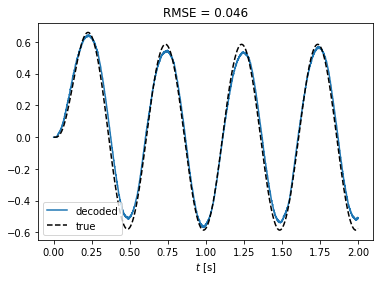

In [50]:
############################################################################
# Testing the trained decoders

# first we have to is change the decoders
decoder_AB_conn.reassign_weights(decoders_AB.T)
decoder_BOut_conn.reassign_weights(decoders_BOut.T)
# then call remap
print("remapping weights")
HAL.remap_weights()

# define input parameters
base_period = 0.5 # seconds
cycles = 4

# create the input
inp_times, inputs_sin = make_sine_stimulus(DinA, base_period, cycles, fmax=fmax, input_dt=input_dt)

# package together inputs and their timestamps
# times must be sent in ns (and thus are multiplied by 1e9)
FUDGE = 2
curr_time = HAL.get_time()
times = curr_time + FUDGE * 1e9 + inp_times * 1e9
times_w_end = np.hstack((times, times[-1] + input_dt * 1e9))
input_vals = {iA : (times, inputs_sin)}

# create the RunControl object for our defined network
rc = RunControl(HAL, net)

# send the input and collect outputs from the output node
# out_dict is a dictionary of output spikes for each output node,
# out_bin_times is a array of bin
outputs_and_bin_times, _ = rc.run_input_sweep(input_vals, get_raw_spikes=False, 
                                              end_time=times_w_end[-1], rel_time=False)

# out_bin_times is length-S, bin-size set by upstream_time_res
# out_dict is a dictionary, out_ct is a S-by-N matrix of output spike counts within S bins
out_dict, out_bin_times = outputs_and_bin_times
out_ct = out_dict[oB]

# convert spike counts to spike train
out_spikes = out_ct / input_dt

# truncate inputs to length of measured outputs
inp_times_trunc = inp_times[:out_spikes.shape[0]]
inputs_sin_trunc = inputs_sin[:out_spikes.shape[0]]

# filter the decoded spikes to generate the output signal
fh_B = probe.filt(out_spikes, y0=0, dt=input_dt)

# create the desired function for comparison
x = syn_A.filt(inputs_sin_trunc, y0=0, dt=input_dt)
fx = func_f(x)
y = syn_B.filt(fx, y0=0, dt=input_dt)
gy = func_g(y)
f_B = probe.filt(gy, y0=0, dt=input_dt)

# rescale by fmax and fmax_out to return to consistent units
fh_B_out = fh_B / fmax_out_B
f_B_out = f_B / fmax

# compute rmse
rmse = np.sqrt(np.mean((f_B_out - fh_B_out)**2))

plt.figure()
plt.title('RMSE = %.3f' % rmse)
plt.plot(inp_times_trunc, fh_B_out, label='decoded')
plt.plot(inp_times_trunc, f_B_out, '--k', label='true')
plt.xlabel(r'$t$ [s]')
plt.legend()



## 4 Visualizing Tuning Curves
Generating tuning curves from spike data can be done in one of two ways, depending on the way spike data is represented. We'll begin with the most straightforward method: driving our ensemble with $Q^D$ uniformly-spaced inputs in $[-f_\mathrm{max}, +f_\mathrm{max}]^D$, holding each input for a fixed duration and estimating each neuron's firing-rate. Then we'll demonstrate how we can still extract this firing-rate information when the tuning curves are represented parametrically. We'll reuse our original network `simple_net` defined in section 1.

### 4.1 Measuring tuning curves from constant input signals
To create this input signal, we use `make_cons_stimulus()`. This function naturally traverses a uniformly-gridded domain and holds inputs for constant durations. After generating the stimulus and creating timestamps for the input, we'll use the RunControl function `run_and_sweep()` to measure binned spike counts. Then, we'll use a utility function in `pystorm.hal.data_utils`, `bins_to_rates()`, to estimate each neuron's spike rate from the bin spike counts.

getting spikes
done


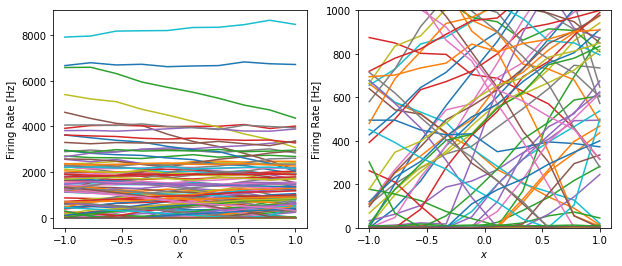

In [89]:
###########################################################################
# Measuring tuning curves and plotting

# the longer the hold time, the more accurately we estimate the spike rate
hold_time = 0.5

# stimulus parameters
Din = 1
Q = 10
fmax = 1000

# generate the input signal
inp_times, inputs_cons = make_cons_stimulus(Din, hold_time, Q, fmax=fmax)

# package together the stopwatch times and input stimuli
# times must be sent in ns (and thus are multiplied by 1e9)
FUDGE = 2
curr_time = HAL.get_time()
times = curr_time + FUDGE * 1e9 + inp_times * 1e9
times_w_end = np.hstack((times, times[-1] + hold_time * 1e9))
input_vals = {i1 : (times, inputs_cons)}

# create the RunControl object for our defined network
rc = RunControl(HAL, simple_net)

# send inputs and collect spikes
print("getting spikes")
_, spikes_and_bin_times = rc.run_input_sweep(input_vals, get_raw_spikes=True, 
                                             end_time=times_w_end[-1], rel_time=False)
print("done")

# parse spike data into bin times and binned spike counts
spike_dict, spike_bin_times = spikes_and_bin_times
spike_ct = spike_dict[p1]

# its arguments are spike counts, original bin times, bin edges, and a discard fraction
# it averages spike count over the holding time, discarding some fraction of initial spikes
# it returns a Q**Din-by-N matrix, exactly corresponding to the tuning curve matrix
A = data_utils.bins_to_rates(spike_ct, spike_bin_times, times_w_end, init_discard_frac=.2)

# plot the tuning curves
x = inputs_cons / fmax
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(x, A[:,::2]);
plt.xlabel(r'$x$')
plt.ylabel('Firing Rate [Hz]');

# only half for some visual clarity
plt.subplot(122)
plt.plot(x, A[:,::2])
plt.ylim([0, 1e3])
plt.xlabel(r'$x$')
plt.ylabel('Firing Rate [Hz]');

### 4.2 Estimating tuning curves from parametric data
We'll now show you how you can estimate tuning curves when neurons' firing-rates are not explicit functions of the input $\mathbf{x}$. Instead, both inputs $\mathbf{x}$ and a $\mathbf{a}$ are functions of time $t$. So long as the input set $\mathcal{X} = \{\mathbf{x}(t) | t \leq T\}$ adequately samples the domain $[-f_\mathrm{max}, +f_\mathrm{max}]$, you can estimate the pool's firing-rate $\mathbf{a}(\mathbf{x}')$ for a new input $\mathbf{x}'$ by interpolating over $\{\mathbf{a}(\mathbf{x}_j), \mathbf{x}_j \in \mathcal{X} \cap\mathcal{N}(\mathbf{x}')\}$.

In the code below, we demonstrate this principle using inputs $x(t)$ generated by `make_sine_inputs()`. To improve the accuracy of the firing-rate estimates, we slow the input oscillation with a longer `base_period` and additional cycles.

In [101]:
def tuning_curve_from_parametric(x_times, x_vals, binned_spk_ct, curve_pts, 
                                 sigma=0.1, threshold=1e-7, default_value=0):
    """
    Estimate the tuning curve, given time-varying spike counts 
    and a time-varying signal
    
    Parameters
    ----------
    x_times: Python list
        list of times (in seconds) that we know the input for
    x_vals: numpy array
        the corresponding input for each time in x_times, in abstract units (not fmax)
    binned_spk_ct: numpy array
        spike counts for each bin
    curve_pts: numpy array
        the x values we want a frequency estimate for, in abstract units (not fmax)
    sigma: float
        std.dev of the gaussian weighting (in x-space)
    threshold: float
        if the total weight is less than this, we have no good estimate
        for this x point
    default_value: int or None
        the value to use if the total weight is less that the threshold 
        (usually 0 or None)

    Returns
    -------
    curve: numpy array
        tuning curve for the given neuron's binned spike counts
    """
    if len(curve_pts.shape) == 1:
        curve_pts = curve_pts.reshape(curve_pts.shape[0],1)
    if len(x_vals.shape) == 1:
        x_vals = x_vals.reshape(x_vals.shape[0],1)
    
    # convert binned spike counts to list of spike times
    spike_times = []
    for j, ct in enumerate(binned_spk_ct[:-1]):
        if ct > 0:
            # ct spikes within a dt are uniformly spaced within the dt
            spike_times.extend(list(np.linspace(x_times[j], x_times[j+1], ct)))
            
    # number of dimensions
    D = x_vals.shape[1]
    
    # throw away spikes that occur at the same time
    t = np.unique(spike_times)
    
    # compute frequency for each inter-spike interval
    freq = 1.0/np.diff(t)
    
    # the midpoints of each inter-spike interval
    t_mid = (t[:-1] + t[1:])/2
    
    # find the x values for each time point in t_mid
    x_mid = scipy.interpolate.griddata(x_times, x_vals, (t_mid,), method='nearest')
    
    # compute the L2 norm (squared) for each pair of points
    #  in x_mid and curve_pts.  That is, find the squared distance in 
    #  x-space between each of the points we're interested in (curve_pts)
    #  and each point we have (x_mid)
    v = np.sum([(x_mid[:,i][:,None]-curve_pts[:,i][None,:])**2 for i in range(D)], axis=0)
    
    # compute the weighting for each point (gaussian weighting)
    w = np.exp(-v/(2*sigma)**2)/(np.sqrt(2*np.pi*sigma**2))
    
    # for each point in curve_pts, determine the frequency using
    #  a weighted average (where the weight is the gaussian based on distance)
    total = np.sum(w, axis=0)
    safe_total = np.where(total<threshold, 1.0, total)
    curve = np.sum(w*freq[:,None], axis=0)/safe_total
    
    # for values where the weights are below some theshold, 
    #  set them to some default value (usually None or 0)
    curve[total<threshold] = default_value
    
    return curve

getting spikes
done


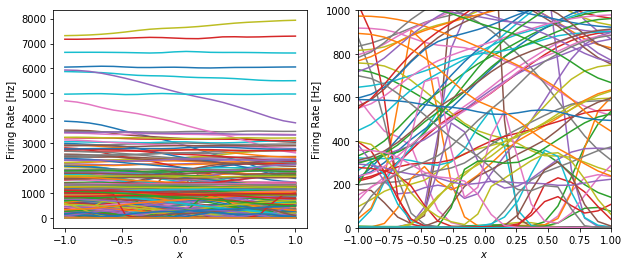

In [102]:
############################################################################
# Estimating tuning curves and plotting

# the longer the period and higher the cycle count, the more densely
# we sample the domain
base_period = 3
cycles = 4

# stimulus parameters
Din = 1
fmax = 1000
input_dt = 1e-3

# generate the input signal
inp_times, inputs_sin = make_sine_stimulus(Din, base_period, cycles, fmax=fmax, input_dt=input_dt)

# package together the stopwatch times and input stimuli
# times must be sent in ns (and thus are multiplied by 1e9)
FUDGE = 2
curr_time = HAL.get_time()
times = curr_time + FUDGE * 1e9 + inp_times * 1e9
times_w_end = np.hstack((times, times[-1] + input_dt * 1e9))
input_vals = {i1 : (times, inputs_sin)}

# send inputs and collect spikes
print("getting spikes")
_, spikes_and_bin_times = rc.run_input_sweep(input_vals, get_raw_spikes=True, 
                                             end_time=times_w_end[-1], rel_time=False)
print("done")

# parse spike data into bin times and binned spike counts
spike_dict, spike_bin_times = spikes_and_bin_times
spike_ct = spike_dict[p1]

# we need to define what the input to the neuron was when it fired at the observed rate
# do this by filtering the stimulus by the pool's synaptic filter
tau_syn = 0.02 # 20 ms
syn = nengo.synapses.Lowpass(tau_syn)
xt = syn.filt(inputs_sin, y0=0, dt=input_dt) / fmax

# we define the x-values that we will estimate firing rates for
Q = 20
x = np.linspace(-1, 1, Q)
Ap = np.zeros((Q, N))

# we go through each neuron's binned spike counts and extract its tuning curve
for n in range(N):
    # since interpolation radius is not defined in units of fmax, we convert inputs_sin
    # and x back to abstract units
    Ap[:,n] = tuning_curve_from_parametric(inp_times, xt, spike_ct[:,n], x)

# plot the tuning curves
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(x, Ap);
plt.xlabel(r'$x$')
plt.ylabel('Firing Rate [Hz]');

# only half for visual clarity
plt.subplot(122)
plt.plot(x, Ap[:,:128])
plt.ylim([0, 1e3])
plt.xlim([-1, 1])
plt.xlabel(r'$x$')
plt.ylabel('Firing Rate [Hz]');